# Problem Set 5 (85 pts)

In this problem set, you'll explore topics in Computer Vision. In particular, you'll work the [Canny Edge Detection algorithm](https://ieeexplore.ieee.org/document/4767851), a foundation computation algorithm for image processing.

In [1]:
### DO NOT CHANGE ###
# importing the libraries (do not remove or add libraries)
from typing import List, Set, Dict, Tuple, Optional
import numpy as np

## Background (0 pts)

In this problem set, you will implement parts of the Canny Edge Detection algorithm from scratch using the NumPy library. Your Canny Edge Detector will take a *grayscale* image and return the image with its edges detected (i.e., apply the canny edge detection algorithm on the image).

Note: the reason for the emphasis on *grayscale* is that the original Canny Edge detection is defined for grayscale images. There is research on expanding to color images, such as this paper: [An improved Canny edge detection algorithm for color image](https://ieeexplore.ieee.org/document/6301061)

There are various versions and nuances on the Canny Edge Detection algorithm, so we'll provide some more, explicit details on the mechanics of the algorithm.

At a high level, the steps of the Canny Edge Detection algorithm are:

1.   Reduce the noise using a Gaussian Kernel / Convolution (pre-filter on the image)
2.   Compute the image gradients (use a gradient approximation operator / kernel / filter)
3.   Apply Non-Maximum Suppression (NMS) which filters out noise around the edges / keeps the maxima points
4.   Apply 2-stage thresholding to remove disconnected weak edges and connect strong edges with adjacent weak edges (hysteresis)

#### Step 1: Noise Reduction with the Gaussian Kernel
The gaussian kernel is defined by this function:

\begin{align}
G_\sigma = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}
\end{align}

The $\sigma$ parameter is the strength of the Gaussian blur. Additionally, the Gaussian kernel is defined by its size $n$ which dictate it's dimension (the bigger the size, the stronger the Gaussian kernel will be). The value of $n$ is an odd number and indicates that the Gaussian kernel will be size $n \times n$.

After we have our Gaussian kernel, we convolve it with the image. To perserve the original dimensions of the image, we should use padding at the boundaries / edges. To avoid our Canny Edge Detection algorithm from picking up false edges at the boundaries of the image, we will extend the image by using pixels at the image boundary, meaning that the extra pixels we pad to the image will take the value of the pixels from the nearest boundary. For pixels padded to the corner, it will take the value of the nearest corner pixel. By padding our image in this fashion, we avoid creating false spikes in our image pixel data (e.g., consider how zero padding might lead to false edges at the boundary of the image).

For your implementation, $\sigma$ and $n$ will be two parameters (there will be called `s` and `n` in the function signatures, respectively).

#### Step 2: Compute the Image Gradients
We need gradients of the image to see where edges are because edges are where pixel values rapidly change value (so their rate of change is high). Unfortunately, we can't mathematically define exact gradients for discrete values such as pixel values. However, we can approximate them. For images, this can be done by using filters / operators such as Sobel, Prewitt, and/or Roberts. These filters / operators define kernels to calculate gradients in the $x$ and $y$ directions - with this information, the true gradient magnitude and direction can be determined.

It should also be noted that there are different variants of these filters, such as different sizes (e.g., $3 \times 3$ Sobel vs $5 \times 5$ Sobel, etc.). For your implementation, you'll work with these variants of the operators.

For Sobel,

$$
G_x = \begin{bmatrix}
    1 & 0 & -1 \\
    2 & 0 & -2 \\
    1 & 0 & -1
\end{bmatrix},
G_y = \begin{bmatrix}
    1 & 2 & 1 \\
    0 & 0 & 0 \\
    -1 & -2 & -1
\end{bmatrix}
$$

For Prewitt,

$$
G_x = \begin{bmatrix}
    1 & 0 & -1 \\
    1 & 0 & -1 \\
    1 & 0 & -1
\end{bmatrix},
G_y = \begin{bmatrix}
    1 & 1 & 1 \\
    0 & 0 & 0 \\
    -1 & -1 & -1
\end{bmatrix}
$$

For Roberts,

$$
G_x = \begin{bmatrix}
    1 & 0 \\
    0 & -1
\end{bmatrix},
G_y = \begin{bmatrix}
    0 & 1 \\
    -1 & 0
\end{bmatrix}
$$

Where $G_x$ is the matrix to approximate gradients in the $x$ direction, and $G_y$ is the matrix to approximate gradients in the $y$ direction. Similar to the Gaussian kernel from step 1, we convolve $G_x$ and $G_y$ with the image. To perserve the original dimensions of the image, we should use padding at the boundaries / edges. We are left with $I_x$ which is the image gradient along the X direction and $I_y$ which is the image gradient along the Y direction. To find the true gradient magnitude and direction, we can use basic trignometry and arrive at:

\begin{align}
|\nabla I| &= \sqrt{I_x^2+I_y^2} \\
\Theta_{\nabla I} &= \text{atan2}(I_y, I_x)
\end{align}

The first equation is for the magnitude of the gradient and the second equation is for the angle that the gradient is pointing in.

For your implementation, `gradient_kernel` will be a parameter. It will be a string flag that will equal `sobel`, `prewitt`, or `roberts` indicating which gradient approximation kernel should be used (i.e., if `gradient_kernel = sobel`, use the sobel operator defined above for gradient calculations).

#### Step 3: Non-Maximum Suppression (NMS) for Image Gradients
Non-Maximum Suppression (NMS) is a crucial step where we filter away all the noisy gradient values and find the places where the gradients truly represent edges. At a high level, NMS looks along the direction that each pixel's gradient points to, and sees if the point has the maximal gradient value along that direction amongst its neighbors (i.e., nearby pixels). If it is maximal, it stays, otherwise it is suppressed (i.e., zero-ed out).

When the gradient points to a neighboring pixel, such as at a $45°$ or $90°$ angle which represents pointing to it's north-east pixel neighbor and it's east pixel neighbor, respectively, it's very clear to which gradient values should be compared. For example, if the gradient points at a $45°$ angle, we would compare the gradient values along that direction, meaning we'd compare gradient values with the north-east pixel and south-west pixel, as those neigboring pixels are along the direction of the gradient. However, when the gradient points in a direction that is between pixels, such as $85°$, then we don't have a direct pixel neighbor to compare with - to resolve this we will either approximate, which means we use the nearest pixel neighbor in that direction, or interpolate what the gradient value would be in that direction.

For this implementation, we'll stick with approximating with the nearest neighbor in the direction of the gradient. From the earlier step, we stated that the angle of the gradient can be determined by the $\text{atan2}$ function. This function returns values between $[-180°, 180°]$.

To make the implementation easier, we can exploit the symmetry with angles. We can relate a negative gradient angle with a positive gradient angle. For example, if the gradient angle was $-135°$, it is along the same axis as a gradient with angle $45°$. Thus, to convert our negative gradients to their corresponding positive gradient, we add $180°$. Thus, our new domain after this transformation is $[0°, 180°]$. Note: although this transformation flips the direction for gradients with negative angles, it doesn't really affect the Canny Edge Detection algorithm because the algorithm compares gradient values along the direction axis (so it compares both the positive and negative direction).

After the above transformation, we'll take those angle values and round it to a value so that the gradient points in a direction of neighboring pixel:
- Gradient angles in $[0°, 22.5°)$ or $[157.5°, 180°]$ will map to $0°$ meaning the gradient points along the east and west direction; thus the gradient value of the pixel should be compared with its east and west neighbor; if it's greater than it's east and west neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.
- Gradient angles in $[22.5°, 67.5°)$ will map to $45°$ meaning the gradient points along the north-east and south-west direction; thus the gradient value of the pixel should be compared with its north-east and south-west neighbor; if it's greater than it's north-east and south-west neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.
- Gradient angles in $[67.5°, 112.5°)$ will map to $90°$ meaning the gradient points along the north and south direction; thus the gradient value of the pixel should be compared with its north and south neighbor; if it's greater than it's north and south neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.
- Gradient angles in $[112.5°, 157.5°)$ will map to $135°$ meaning the gradient points along the north-west and south-east direction; thus the gradient value of the pixel should be compared with its north-west and south-east neighbor; if it's greater than it's north-west and south-east neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.

Note: in this implementation, when we think about a pixel's neighbors, we are look at the $3 \times 3$ window about the pixel (where the pixel is in the center). However, we can also implement this by looking at a bigger window of neighbors such as a $5\times5$ window. For this implementation. we'll only stick with the $3 \times 3$ window.

After this step, a bunch of gradients will go to zero and we'll be left with only gradients that were maximal (in their $3 \times 3$ neighborhood of pixels).

#### Step 4: Two-Stage Hysteresis
The remaining gradients will still be noisy. To handle that noise, we'll apply two stage hysteresis / filtering. We'll define a `high_threshold` and `low_threshold` where `high_threshold` > `low_threshold`. If a pixel value's gradient is above `high_threshold`, it's a strong edge and is kept. If a pixel value's gradient is less than the `low_threshold`, then it's suppressed (goes to zero). If a pixel value's is between the `low_threshold` and `high_threshold` inclusive, then it's considered a weak edge. A weak edge will only remain if one of it's adjacent neigbors (for this implementation, it is the $3 \times 3$ window centered on the pixel) is marked as a strong edge.

Since the actual gradient values are arbitary (in the sense that the range of gradient values will be different for different images and gradient approximation kernel), we'll standardize them at this point so that the `high_threshold` and `low_threshold` have a standard range for any image or gradient approximation kernel. Scale the gradient value such that all the gradient values are now numbers between 0 to 1 (where the smallest gradient value mapped to 0 and the largest gradient value mapped to 1). This can be acheived by taking each gradient value, subtracting the smallest gradient value and then dividing by the difference between largest and smallest gradient value (this effectively shifts the gradient range to start at zero and scales it to be between 0 and 1). With this, the `high_threshold` and `low_threshold` parameters will be float numbers between `0` and `1`.

The pixel values that correspond to an edge will stay and everything else will go to zero. In the end, we'll be left with a binary map of which pixels correspond to edges.

For your implementation, `high_threshold` and `low_threshold` will be parameters.

#### Results and Other Notes
The return value should be a matrix that is the original dimension as the input image `img`. Furthermore, the matrix should be matrix of `0` and `1` where `0` represents no edge and `1` represents an edge.

Some notes:
- Be wary of edges / corners - you'll need to have special logic / exceptions to handle them
- Pay attention to the shape of the matrices and units (i.e., degrees vs radians)
- For numeric stability, a common pre-processing step in computer vision is to normalize our images, such that values fall between 0 and 1. Since pixel values can take on values between 0 to 255 inclusive, a simple way to normalize images is to rescale the pixel values by a factor of $\frac{1}{255}$

## Utility Functions (25 pts)

In this section, you'll create several utility (helper) functions that maybe useful as you work through implementing the Canny Edge Detection algorithm.

### Gaussian Function (5 pts)

`gaussian_function` (5 pts). Implement the gaussian function used for creating the gaussian blur kernel where `s` is the $\sigma$, `x` is $x$, and `y` is $y$. Assume $\sigma > 0$. For reference, here's the gaussian function that is used:

\begin{align}
G_\sigma(x, y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}
\end{align}

#### Examples

##### Example 1

```python
s = 1
x = 0
y = 0

gaussian_function(s, x, y) = 0.15915494309189535
```
**Explanation**: Applying the formula, we have $G_1(0, 0) = \frac{1}{2\pi(1^2)}e^{-\frac{(0^2)+(0^2)}{2(1^2)}} = 0.15915494309189535$

##### Example 2



```python
s = 2
x = 1
y = 0

gaussian_function(s, x, y) = 0.035113436077406295
```
**Explanation**: Applying the formula, we have $G_2(1, 0) = \frac{1}{2\pi(2^2)}e^{-\frac{(1^2)+(0^2)}{2(2^2)}} = 0.035113436077406295$

#### Implementation

In [2]:
def gaussian_function(s: float, x: int, y: int) -> float:
    return (1/(2*np.pi*(s**2))*np.exp(-(x**2+y**2)/(2*s**2)))

### Add One Layer Continue Padding (5 pts)

`add_one_layer_continue_padding` (5 pts). Given a grayscale image matrix `img`, with height `H` and width `W` (i.e., shape `(H, W)`), extend the image with 1 layer of padding around the image. Extend the image by using pixels at the image boundary, meaning that the extra pixels we pad to the image will take the value of the pixels from the nearest boundary. For pixels padded to the corner, it will take the value of the nearest corner pixels.

#### Examples

##### Example 1

```python
img = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]

add_one_layer_continue_padding(img) = [
    [1, 1, 2, 3, 3],
    [1, 1, 2, 3, 3],
    [4, 4, 5, 6, 6],
    [7, 7, 8, 9, 9],
    [7, 7, 8, 9, 9]
]
```

**Explanation**: Extend the boundaries of the image with pixel value closest to the boundaries. For corner pixels, use the nearest corner pixel.

##### Example 2

```python
img = [
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
]

add_one_layer_continue_padding(img) = [
    [1, 1, 2, 3, 4, 4],
    [1, 1, 2, 3, 4, 4],
    [5, 5, 6, 7, 8, 8],
    [9, 9, 10, 11, 12, 12],
    [9, 9, 10, 11, 12, 12],
]
```

**Explanation**: Extend the boundaries of the image with pixel value closest to the boundaries. For corner pixels, use the nearest corner pixel.

#### Implementation

In [3]:
def add_one_layer_continue_padding(img: np.ndarray) -> np.ndarray:
    return np.pad(img, 1, mode='edge')

### Convolve (5 pts)

`convolve` (5 pts). Given a grayscale image matrix `img`, with height `H` and width `W` (i.e., shape `(H, W)`), and a `kernel`, apply convolution on the image `img` with the `kernel`. Ensure that the resulting image is the same height `H` and width `W` by using the padding scheme described for `add_one_layer_continue_padding`. Note: depending on the `kernel` size, additional layers of padding might be required. Furthermore, assume the shape of the `kernel` is $n \times n$ where $n$ is an odd, positive number (i.e. square matrix with odd-numbered dimensions).

#### Examples

##### Example 1

```python
img = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]
kernel = [
    [4, 0, -3],
    [-3, 2, 2],
    [-2, 1, 1]
]

convolve(img, kernel) = [
    [ 2,  5,  7],
    [ 5,  8, 10],
    [11, 14, 16]
]
```

**Explanation**: applying the kernel at each pixel in the `img` gives us the final result. For the center pixel, no padded values are needed since the `kernel` is $3 \times 3$. For the corner / boundary pixels, padded values were used (need one layer of padding).

##### Example 2

```python
img = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]
kernel = [
    [4, 0, -3, 2, 3],
    [-3, 2, 2, 1, 0],
    [-2, 1, 1, 2, -8],
    [-1, 3, -6, 7, 1],
    [2, 1, 0, 0, 1],
]

convolve(img, kernel) = [
    [52, 58, 59],
    [46, 52, 53],
    [34, 40, 41],
]
```

**Explanation**: applying the kernel at each pixel in the `img` gives us the final result. For the center pixel, padded values are needed since the `kernel` is $5 \times 5$, so one layer of padded values were used. For the corner / boundary pixels, padded values were used (need two layers of padding).

#### Implementation

In [4]:
def convolve(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    n, m = kernel.shape  # Kernel shape

    assert n == m, "Kernel must be a square matrix!"
    assert n % 2 == 1, "Kernel size must be an odd number!"

    pad_size = int((n-1)/2)
    padded_img = np.pad(img, pad_size, mode='edge')

    # Initialize the output image
    H, W = img.shape
    output_img = np.zeros((H, W), dtype='float')

    #flipped_kernel = np.flip(np.flip(kernel, 0), 1)
    for i in range(H):
        for j in range(W):
            output_img[i, j] = np.sum(padded_img[i:i+n, j:j+n] * kernel)
    return output_img

### Normalize Image (5 pts)

`normalize_image` (5 pts). Given a grayscale image matrix `img`, with height `H` and width `W` (i.e., shape `(H, W)`), normalize the pixel values. The resulting image will take values between 0 and 1. The way to normalize an image is to scale each pixel in the image by $\frac{1}{255}$.

#### Examples

##### Example 1

```python
img = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
]

normalize_image(img) = [
    [0.00392156862745098, 0.00784313725490196, 0.011764705882352941],
    [0.01568627450980392, 0.0196078431372549, 0.023529411764705882],
    [0.027450980392156862, 0.03137254901960784, 0.03529411764705882],
]
```

**Explanation**: normalize the `img` matrix by dividing each value by 255.

##### Example 2

```python
img = [
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
]

normalize_image(img) = [
    [0.00392156862745098, 0.00784313725490196, 0.011764705882352941, 0.01568627450980392],
    [0.0196078431372549, 0.023529411764705882, 0.027450980392156862, 0.03137254901960784],
    [0.03529411764705882, 0.0392156862745098, 0.043137254901960784, 0.047058823529411764],
]
```

**Explanation**: normalize the `img` matrix by dividing each value by 255.

#### Implementation

In [5]:
def normalize_image(img: np.ndarray) -> np.ndarray:
    return img/255

### Rescale Matrix (5 pts)

`rescale_matrix` (5 pts). Given a 2D matrix, `M`, with height `H` and width `W` (i.e., shape `(H, W)`), rescale the values such that they fall between 0 and 1 (where the smallest gradient value mapped to 0 and the largest gradient value mapped to 1). This can be acheived by taking each gradient value, subtracting the smallest gradient value and then dividing by the difference between largest and smallest gradient value (this effectively shifts the gradient range to start at zero and scales it to be between 0 and 1).

#### Examples

##### Example 1

```python
M = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
]

rescale_matrix(M) = [
    [0.0, 0.125, 0.25],
    [0.375, 0.5, 0.625],
    [0.75, 0.875, 1.0],
]
```

**Explanation**: The smallest value in `M` is 1 and the largest value in `M` is 9. The difference between the largest and smallest value is 8. To get our rescaled matrix, we subtract the smallest value, 1, from every cell and then divide by difference, 8.

##### Example 2

```python
M = [
    [-4, -3, -2, -1],
    [0, 1, 2, 3],
    [4, 5, 6, 7],
]

rescale_matrix(M) = [
    [0.0, 0.09090909090909091, 0.18181818181818182, 0.2727272727272727],
    [0.36363636363636365, 0.45454545454545453, 0.5454545454545454, 0.6363636363636364],
    [0.7272727272727273, 0.8181818181818182, 0.9090909090909091, 1.0],
]
```

**Explanation**: The smallest value in `M` is -4 and the largest value in `M` is 7. The difference between the largest and smallest value is 11. To get our rescaled matrix, we subtract the smallest value, -4, from every cell and then divide by difference, 11. (Note: since the smallest value is a negative number, we're actually adding 4 to every value).

#### Implementation

In [6]:
def rescale_matrix(M: np.ndarray) -> np.ndarray:
    min_val = M.min()
    range_val = M.max() - min_val

    # Avoid division by zero in case it's a blank piece of paper
    if range_val == 0:
        return np.zeros_like(M)

    return (M - min_val) / range_val

## Step 1: Noise Reduction with the Gaussian Kernel (5 pts)

In this section, you'll implement functions for Step 1: Noise Reduction with the Gaussian.

### Gaussian Kernel (5 pts)

`gaussian_kernel` (5 pts). Create a `n` by `n` gaussian kernel with $\sigma =$ `s`. For this problem `n` will always be a positive, odd number. Assume $\sigma > 0$. The return type is `np.ndarray` with shape `(n,n)`.

#### Examples

##### Example 1

```python
s = 1
n = 5

gaussian_kernel(s, n) = [
    [0.0029150244650281935, 0.013064233284684921, 0.021539279301848627, 0.013064233284684921, 0.0029150244650281935],
    [0.013064233284684921, 0.058549831524319175, 0.09653235263005391, 0.058549831524319175, 0.013064233284684921],
    [0.021539279301848627, 0.09653235263005391, 0.15915494309189535, 0.09653235263005391, 0.021539279301848627],
    [0.013064233284684921, 0.058549831524319175, 0.09653235263005391, 0.058549831524319175, 0.013064233284684921],
    [0.0029150244650281935, 0.013064233284684921, 0.021539279301848627, 0.013064233284684921, 0.0029150244650281935],
]
```

**Explanation**: The kernel matrix is 5 by 5 since `n = 5`. The center of the matrix correspond to $G_{\sigma}(0, 0)$ where $\sigma = 1$ since `s = 1`, using the gaussian function defined earlier. The other entries are $G_{\sigma}(x, y)$ where $x$ and $y$ is the how far horizontally and vertically, respectively, it is from the center.

##### Example 2

```python
s = 2
n = 3

gaussian_kernel(s, n) = [
    [0.030987498577413244, 0.035113436077406295, 0.030987498577413244],
    [0.035113436077406295, 0.039788735772973836, 0.035113436077406295],
    [0.030987498577413244, 0.035113436077406295, 0.030987498577413244],
]
```

**Explanation**: The kernel matrix is 3 by 3 since `n = 3`. The center of the matrix correspond to $G_{\sigma}(0, 0)$ where $\sigma = 2$ since `s = 2`, using the gaussian function defined earlier. The other entries are $G_{\sigma}(x, y)$ where $x$ and $y$ is the how far horizontally and vertically, respectively, it is from the center.

#### Implementation

In [7]:
def gaussian_kernel(s: float, n: int) -> np.ndarray:

    assert n % 2 == 1, "n must be an odd number!"
    assert s > 0, "variance must be positive!"

    # Calculate the Gaussian function for each element in the meshgrid
    ax = np.linspace(-(n - 1) / 2, (n - 1) / 2, n)
    xx, yy = np.meshgrid(ax, ax, sparse=True)

    return np.exp(-(xx**2 + yy**2) / (2 * (s**2)))/(2*np.pi*(s**2))

### Noise Reduction Demo (0 pts)

After implementing all of the above functions, you can experiment with denoising an image with the Gaussian kernel with a sample image. Feel free to provide a `url` link to an image or a google drive link to an image (make sure the permission is set to view access to anyone with the link; [steps can be found here](https://support.google.com/docs/answer/2494822?hl=en&co=GENIE.Platform%3DDesktop)) and experiment with the `s` and `n` parameter. Note: the results are much more distinguishable when the image is lower resolution / smaller.

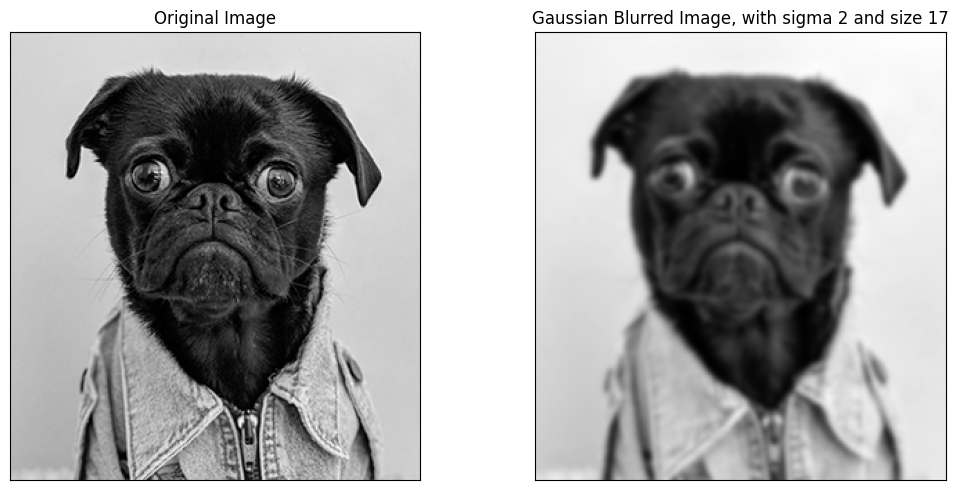

In [12]:
### DO NOT CHANGE ###
#@title Experiment with Gaussian Kernel { run: "auto" }
if __name__ == "__main__":

    import importlib
    import subprocess
    def check_and_install_library(library_name):
        try:
            importlib.import_module(library_name)
        except ImportError:
            subprocess.call(["pip", "-q", "install", library_name])

    check_and_install_library("wget")

    import wget
    import gdown
    import matplotlib.pyplot as plt
    import time
    import cv2
    import re
    from urllib.error import HTTPError

    class StopExecution(Exception):
        def _render_traceback_(self):
            pass

    url = "https://drive.google.com/file/d/15HWhYP_Kjbsz5AusTuuZtLi9nmTGiviY/view?usp=drive_link" #@param { type: "string" }
    s = 2 #@param { type: "slider", min: 1, max: 20, step: 1}
    n = 17 #@param { type: "slider", min: 3, max: 25, step: 2}

    now = time.strftime("%Y%m%d-%H%M%S")
    file_name = f"img_{now}.jpeg"

    if "drive.google.com" in url:
        id_match = re.search(r'/d/([a-zA-Z0-9_-]+)', url)
        if id_match:
            extracted_id = id_match.group(1)
        else:
            print(f"ERROR: Invalid Google Drive URL - provide another URL")
            raise StopExecution

        try:
            gdown.download(f"https://drive.google.com/uc?id={extracted_id}", file_name, quiet=True)
        except gdown.exceptions.FileURLRetrievalError:
            print(f"ERROR: Invalid Google Drive URL - please check the access permission or that the file exists or provide another URL")
            raise StopExecution
        except Exception as e:
            print(f"ERROR: Please contact course staff; failed to perform wget on image URL due to: {e}")
            raise StopExecution
    else:
        try:
            wget.download(url, file_name)
        except TypeError:
            print(f"ERROR: Invalid Image URL - provide another URL")
            raise StopExecution
        except HTTPError:
            print(f"ERROR: Failed make HTTP request to Image URL - provide another URL")
            raise StopExecution
        except Exception as e:
            print(f"ERROR: Please contact course staff; failed to perform wget on image URL due to: {e}")
            raise StopExecution

    try:
        img = cv2.imread(file_name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gaussian_filtered_img = convolve(img, gaussian_kernel(s, n))

        fig, ax = plt.subplots(1, 2, figsize=(11, 5))
        ax[0].imshow(img, cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(gaussian_filtered_img, cmap="gray")
        ax[1].set_title(f"Gaussian Blurred Image, with sigma {s} and size {n}")
        for index, a in enumerate(ax):
            a.set_xticks([])
            a.set_yticks([])
        plt.tight_layout()
        plt.show()
    except NameError as e:
        print(f"ERROR: It appears some of the above code cells were not ran; please run the above code cell(s): {e}")
        raise StopExecution
    except Exception:
        print(f"ERROR: Required implementation is incorrect or incomplete")
        raise StopExecution



## Step 2: Compute the Image Gradients (25 pts)

In this section, you'll implement functions for Step 2: Compute the Image Gradients.

### Gradients XY Sobel (5 pts)

`gradients_xy_sobel` (5 pts). Given an grayscale image matrix `img`, with height `H` and width `W` (i.e., shape `(H, W)`), determine the gradients in the `x` direction, $I_x$, and the gradients in the `y` direction, $I_y$, using convolution with the Sobel operator. Note: the output should be a tuple $(I_x, I_y)$, in that order, where both $I_x$ and $I_y$ are shape `(H, W)`.

Recall, the Sobel kernels are,
$$
G_x = \begin{bmatrix}
    1 & 0 & -1 \\
    2 & 0 & -2 \\
    1 & 0 & -1
\end{bmatrix},
G_y = \begin{bmatrix}
    1 & 2 & 1 \\
    0 & 0 & 0 \\
    -1 & -2 & -1
\end{bmatrix}
$$

#### Examples

##### Example 1

```python
img = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
]

gradients_xy_sobel(img) = (
    [
        [-4, -8, -4],
        [-4, -8, -4],
        [-4, -8, -4],
    ],
    [
        [-12, -12, -12],
        [-24, -24, -24],
        [-12, -12, -12],
    ]
)
```

**Explanation**: The tuple contains the result from convolving $G_x$ and $G_y$ with the image, respectively.

##### Example 2

```python
img = [
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
]

gradients_xy_sobel(img) = (
    [
        [-4, -8, -8, -4],
        [-4, -8, -8, -4],
        [-4, -8, -8, -4],
    ],
    [
        [-16, -16, -16, -16],
        [-32, -32, -32, -32],
        [-16, -16, -16, -16],
    ]
)
```

**Explanation**: The tuple contains the result from convolving $G_x$ and $G_y$ with the image, respectively.

#### Implementation

In [13]:
def gradients_xy_sobel(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Sobel operator kernels (sobel_x flipped from lecture notes)
    sobel_x = np.flip(np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]))
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # Compute gradients in the x and y directions
    Ix = convolve(img, sobel_x)
    Iy = convolve(img, sobel_y)

    return (Ix, Iy)


### Gradients XY Prewitt (5 pts)

`gradients_xy_prewitt` (5 pts). Given an grayscale image matrix `img`, with height `H` and width `W` (i.e., shape `(H, W)`), determine the gradients in the `x` direction, $I_x$, and the gradients in the `y` direction, $I_y$, using convolution with the Prewitt operator. Note: the output should be a tuple $(I_x, I_y)$, in that order, where both $I_x$ and $I_y$ are shape `(H, W)`.

Recall, the Prewitt kernels are,
$$
G_x = \begin{bmatrix}
    1 & 0 & -1 \\
    1 & 0 & -1 \\
    1 & 0 & -1
\end{bmatrix},
G_y = \begin{bmatrix}
    1 & 1 & 1 \\
    0 & 0 & 0 \\
    -1 & -1 & -1
\end{bmatrix}
$$

#### Examples

##### Example 1

```python
img = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
]

gradients_xy_prewitt(img) = (
    [
        [-3, -6, -3],
        [-3, -6, -3],
        [-3, -6, -3],
    ],
    [
        [-9, -9, -9],
        [-18, -18, -18],
        [-9, -9, -9],
    ]
)
```

**Explanation**: The tuple contains the result from convolving $G_x$ and $G_y$ with the image, respectively.

##### Example 2

```python
img = [
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
]

gradients_xy_prewitt(img) = (
    [
        [-3, -6, -6, -3],
        [-3, -6, -6, -3],
        [-3, -6, -6, -3],
    ],
    [
        [-12, -12, -12, -12],
        [-24, -24, -24, -24],
        [-12, -12, -12, -12],
    ]
)
```

**Explanation**: The tuple contains the result from convolving $G_x$ and $G_y$ with the image, respectively.

#### Implementation

In [14]:
def gradients_xy_prewitt(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # the Prewitt kernels
    G_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    G_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

    # Compute gradients in the x and y directions
    Ix = convolve(img, G_x)
    Iy = convolve(img, G_y)

    return (Ix, Iy)

### Gradients XY Roberts (5 pts)

`gradients_xy_roberts` (5 pts). Given an grayscale image matrix `img`, with height `H` and width `W` (i.e., shape `(H, W)`), determine the gradients in the `x` direction, $I_x$, and the gradients in the `y` direction, $I_y$, using convolution with the Roberts operator. Note: the output should be a tuple $(I_x, I_y)$, in that order, where both $I_x$ and $I_y$ are shape `(H, W)`.

Recall, the Roberts kernels are,
$$
G_x = \begin{bmatrix}
    1 & 0 \\
    0 & -1
\end{bmatrix},
G_y = \begin{bmatrix}
    0 & 1 \\
    -1 & 0
\end{bmatrix}
$$

Notice, the Roberts kernels are $2 \times 2$, which can make them hard to convolve with. To make the convolution behavior more nice, we can pad the Roberts kernels to make them $3 \times 3$ and convolve with those kernels. For this problem, use the below version of the Roberts kernels.

$$
G_x = \begin{bmatrix}
    1 & 0 & 0\\
    0 & -1 & 0 \\
    0 & 0 & 0
\end{bmatrix},
G_y = \begin{bmatrix}
    0 & 1 & 0\\
    -1 & 0 & 0 \\
    0 & 0 & 0
\end{bmatrix}
$$

#### Examples

##### Example 1

```python
img = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
]

gradients_xy_roberts(img) = (
    [
        [0, -1, -1],
        [-3, -4, -4],
        [-3, -4, -4],
    ],
    [
        [0, 1, 1],
        [-3, -2, -2],
        [-3, -2, -2],
    ]
)
```

**Explanation**: The tuple contains the result from convolving $G_x$ and $G_y$ with the image, respectively.

##### Example 2

```python
img = [
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
]

gradients_xy_roberts(img) = (
    [
        [0, -1, -1, -1],
        [-4, -5, -5, -5],
        [-4, -5, -5, -5],
    ],
    [
        [0, 1, 1, 1],
        [-4, -3, -3, -3],
        [-4, -3, -3, -3],
    ]
)
```

**Explanation**: The tuple contains the result from convolving $G_x$ and $G_y$ with the image, respectively.

#### Implementation

In [15]:
def gradients_xy_roberts(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # the modified Roberts kernels
    R_x = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]])
    R_y = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]])

    # Compute gradients in the x and y directions
    Ix = convolve(img, R_x)
    Iy = convolve(img, R_y)

    return (Ix, Iy)


### Gradient Magnitude (5 pts)

`gradient_magnitude` (5 pts). Given the gradients in the `x` direction, $I_x$, and the gradients in the `y` direction, $I_y$, both shape `(H, W)`, return the gradient magnitude, $|\nabla I|$. The output should be the $|\nabla I|$ matrix and have shape `(H, W)`.

Recall,
\begin{align}
|\nabla I| &= \sqrt{I_x^2+I_y^2}
\end{align}

#### Examples

##### Example 1

```python
Ix = [
    [-4, -8, -4],
    [-4, -8, -4],
    [-4, -8, -4],
]
Iy = [
    [-12, -12, -12],
    [-24, -24, -24],
    [-12, -12, -12],
]

gradient_magnitude(Ix, Iy) = [
    [12.649110640673518, 14.422205101855956, 12.649110640673518],
    [24.331050121192877, 25.298221281347036, 24.331050121192877],
    [12.649110640673518, 14.422205101855956, 12.649110640673518],
]
```

**Explanation**: We get the magnitude matrix by taking each entry in $I_x$ and $I_y$ and applying the formula.

##### Example 2

```python
Ix = [
    [-4, -8, -8, -4],
    [-4, -8, -8, -4],
    [-4, -8, -8, -4],
]
Iy = [
    [-16, -16, -16, -16],
    [-32, -32, -32, -32],
    [-16, -16, -16, -16],
]

gradient_magnitude(Ix, Iy) = [
    [16.492422502470642, 17.88854381999832, 17.88854381999832, 16.492422502470642],
    [32.2490309931942, 32.984845004941285, 32.984845004941285, 32.2490309931942],
    [16.492422502470642, 17.88854381999832, 17.88854381999832, 16.492422502470642],
]
```

**Explanation**: We get the magnitude matrix by taking each entry in $I_x$ and $I_y$ and applying the formula.

#### Implementation

In [16]:
def gradient_magnitude(Ix: np.ndarray, Iy: np.ndarray) -> np.ndarray:
    return np.sqrt(Ix**2 + Iy**2)

### Gradient Direction (5 pts)

`gradient_direction` (5 pts). Given the gradients in the `x` direction, $I_x$, and the gradients in the `y` direction, $I_y$, both shape `(H, W)`, return the gradient directions, $\Theta_{\nabla I}$. The output should be the $\Theta_{\nabla I}$ matrix and have shape `(H, W)`. Furthermore, the units in the $\Theta_{\nabla I}$ matrix should be in radians.

Recall,
\begin{align}
\Theta_{\nabla I} &= \text{atan2}(I_y, I_x)
\end{align}

**Hint**: use [`np.arctan2`](https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html)

#### Examples

##### Example 1

```python
Ix = [
    [-4, -8, -4],
    [-4, -8, -4],
    [-4, -8, -4],
]
Iy = [
    [-12, -12, -12],
    [-24, -24, -24],
    [-12, -12, -12],
]

gradient_direction(Ix, Iy) = [
    [-1.8925468811915387, -2.1587989303424644, -1.8925468811915387],
    [-1.7359450042095235, -1.8925468811915387, -1.7359450042095235],
    [-1.8925468811915387, -2.1587989303424644, -1.8925468811915387],
]
```

**Explanation**: We get the direction matrix by taking each entry in $I_x$ and $I_y$ and applying the formula.

##### Example 2

```python
Ix = [
    [-4, -8, -8, -4],
    [-4, -8, -8, -4],
    [-4, -8, -8, -4],
]
Iy = [
    [-16, -16, -16, -16],
    [-32, -32, -32, -32],
    [-16, -16, -16, -16],
]

gradient_direction(Ix, Iy) = [
    [-1.8157749899217608, -2.0344439357957027, -2.0344439357957027, -1.8157749899217608],
    [-1.695151321341658, -1.8157749899217608, -1.8157749899217608, -1.695151321341658],
    [-1.8157749899217608, -2.0344439357957027, -2.0344439357957027, -1.8157749899217608],
]
```

**Explanation**: We get the direction matrix by taking each entry in $I_x$ and $I_y$ and applying the formula.

#### Implementation

In [17]:
def gradient_direction(Ix: np.ndarray, Iy: np.ndarray) -> np.ndarray:
    return np.arctan2(Iy, Ix)

### Image Gradients Demo (0 pts)

After implementing all of the above functions, you can experiment with / visualize the gradients. Feel free to provide a `url` link to an image or a google drive link to an image (make sure the permission is set to view access to anyone with the link; [steps can be found here](https://support.google.com/docs/answer/2494822?hl=en&co=GENIE.Platform%3DDesktop)) and changing the gradient operator (between `Sobel`, `Prewitts`, and `Roberts`). Note: the gradient visualizations pre-processes the original image with a gaussian kernel of size $5 \times 5$ with $\sigma = 3$.

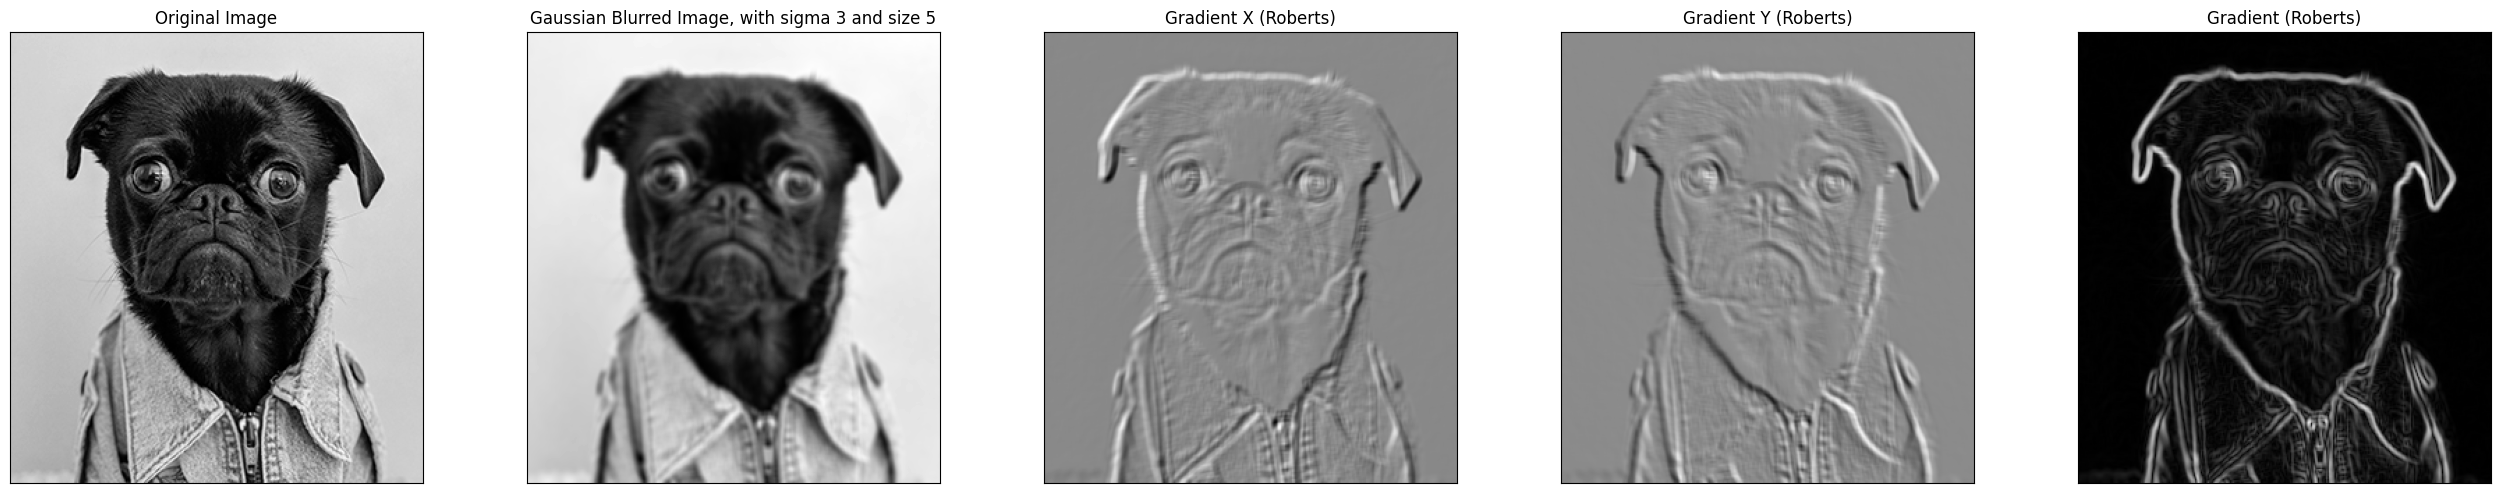

In [20]:
### DO NOT CHANGE ###
#@title Experiment with Image Gradients { run: "auto" }
if __name__ == "__main__":

    import importlib
    import subprocess
    def check_and_install_library(library_name):
        try:
            importlib.import_module(library_name)
        except ImportError:
            subprocess.call(["pip", "-q", "install", library_name])

    check_and_install_library("wget")

    import wget
    import gdown
    import matplotlib.pyplot as plt
    import time
    import cv2
    import re
    from urllib.error import HTTPError

    class StopExecution(Exception):
        def _render_traceback_(self):
            pass

    url = "https://drive.google.com/file/d/15HWhYP_Kjbsz5AusTuuZtLi9nmTGiviY/view?usp=drive_link" #@param { type: "string" }
    s = 3
    n = 5
    gradient_kernel = "Roberts" #@param ["Sobel", "Prewitt", "Roberts"]

    now = time.strftime("%Y%m%d-%H%M%S")
    file_name = f"img_{now}.jpeg"

    if "drive.google.com" in url:
        id_match = re.search(r'/d/([a-zA-Z0-9_-]+)', url)
        if id_match:
            extracted_id = id_match.group(1)
        else:
            print(f"ERROR: Invalid Google Drive URL - provide another URL")
            raise StopExecution

        try:
            gdown.download(f"https://drive.google.com/uc?id={extracted_id}", file_name, quiet=True)
        except gdown.exceptions.FileURLRetrievalError:
            print(f"ERROR: Invalid Google Drive URL - please check the access permission or that the file exists or provide another URL")
            raise StopExecution
        except Exception as e:
            print(f"ERROR: Please contact course staff; failed to perform wget on image URL due to: {e}")
            raise StopExecution
    else:
        try:
            wget.download(url, file_name)
        except TypeError:
            print(f"ERROR: Invalid Image URL - provide another URL")
            raise StopExecution
        except HTTPError:
            print(f"ERROR: Failed make HTTP request to Image URL - provide another URL")
            raise StopExecution
        except Exception as e:
            print(f"ERROR: Please contact course staff; failed to perform wget on image URL due to: {e}")
            raise StopExecution

    try:
        img = cv2.imread(file_name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gaussian_filtered_img = convolve(img, gaussian_kernel(s, n))
        if gradient_kernel == "Sobel":
            Ix, Iy = gradients_xy_sobel(gaussian_filtered_img)
        elif gradient_kernel == "Prewitt":
            Ix, Iy = gradients_xy_prewitt(gaussian_filtered_img)
        elif gradient_kernel == "Roberts":
            Ix, Iy = gradients_xy_roberts(gaussian_filtered_img)

        G_magnitude = gradient_magnitude(Ix, Iy)

        fig, ax = plt.subplots(1, 5, figsize=(26, 5))
        ax[0].imshow(img, cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(gaussian_filtered_img, cmap="gray")
        ax[1].set_title(f"Gaussian Blurred Image, with sigma {s} and size {n}")
        ax[2].imshow(Ix, cmap="gray")
        ax[2].set_title(f"Gradient X ({gradient_kernel})")
        ax[3].imshow(Iy, cmap="gray")
        ax[3].set_title(f"Gradient Y ({gradient_kernel})")
        ax[4].imshow(G_magnitude, cmap="gray")
        ax[4].set_title(f"Gradient ({gradient_kernel})")
        for index, a in enumerate(ax):
            a.set_xticks([])
            a.set_yticks([])
        plt.tight_layout()
        plt.show()
    except NameError as e:
        print(f"ERROR: It appears some of the above code cells were not ran; please run the above code cell(s): {e}")
        raise StopExecution
    except Exception:
        print(f"ERROR: Required implementation is incorrect or incomplete")
        raise StopExecution

## Step 3: Non-Maximum Suppression (NMS) for Image Gradients (15 pts)

In this section, you'll implement functions for Step 3: Non-Maximum Suppression (NMS) for Image Gradients.

### Prep for NMS (5 pts)

`prep_for_NMS` (5 pts). The matrix that is returned from `gradient_direction` is in radians and has values between $-\pi$ to $\pi$. For our Non-Maximum Suppression algorithm, we want to first transform these values to degrees and make the range of values be from $0°$ to $180°$. Implement `prep_for_NMS` that takes the matrix returned from `gradient_direction` and applies those transformation. The input and output matrix will have the same shape.

**Hint**: To convert radians to degrees, use [`np.degrees`](https://numpy.org/doc/stable/reference/generated/numpy.degrees.html). To scale the values from $[-180°, 180°]$ to $[0°, 180°]$, add $180°$ to all the values that are less than $0°$ (this works due to the geometry / symmetry of angles).

#### Examples

##### Example 1

```python
M = [
    [-1.892, -2.158, -1.892],
    [-1.735, -1.892, -1.735],
    [-1.892, -2.158, -1.892],
]

prep_for_NMS(M) = [
    [71.59638516124825, 56.35570781076835, 71.59638516124825],
    [80.59182254480217, 71.59638516124825, 80.59182254480217],
    [71.59638516124825, 56.35570781076835, 71.59638516124825],
]
```

**Explanation**: Convert each entry in `M` from radians to degrees. Any values that are negative, add 180 to them.


##### Example 2

```python
M = [
    [-1.815, -2.034, -2.034, -1.815],
    [-1.695, -1.815, -1.815, -1.695],
    [-1.815, -2.034, -2.034, -1.815],
]

prep_for_NMS(M) = [
    [76.00816018375559, 63.460384470390565, 63.460384470390565, 76.00816018375559],
    [82.88365372532546, 76.00816018375559, 76.00816018375559, 82.88365372532546],
    [76.00816018375559, 63.460384470390565, 63.460384470390565, 76.00816018375559],
]
```

**Explanation**: Convert each entry in `M` from radians to degrees. Any values that are negative, add 180 to them.


#### Implementation

In [21]:
def prep_for_NMS(M:np.ndarray)-> np.ndarray:
    grad_direction_degrees = np.degrees(M)
    # Adjust values to be from 0° to 180°
    grad_direction_degrees[grad_direction_degrees < 0] += 180
    return grad_direction_degrees

### NMS (10 pts)

`NMS` (10 pts). Given the gradient magnitude matrix returned from `gradient_magnitude`, `G_magnitude`, and the transformed gradient angle matrix returned from `prep_for_NMS`, `G_angle`, perform non-maximum suppression. Both input matrix will have same shape. The output should be a matrix of the same shape, as well. The output matrix should have the gradient value from `G_magnitude` if that gradient value is maximal along its direction, otherwise it should be set to 0.

The non-maximum suppression algorithm is:
- Gradient angles in $[0°, 22.5°)$ or $[157.5°, 180°]$ will map to $0°$ meaning the gradient points along the east and west direction; thus the gradient value of the pixel should be compared with its east and west neighbor; if it's greater than it's east and west neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.
- Gradient angles in $[22.5°, 67.5°)$ will map to $45°$ meaning the gradient points along the north-east and south-west direction; thus the gradient value of the pixel should be compared with its north-east and south-west neighbor; if it's greater than it's north-east and south-west neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.
- Gradient angles in $[67.5°, 112.5°)$ will map to $90°$ meaning the gradient points along the north and south direction; thus the gradient value of the pixel should be compared with its north and south neighbor; if it's greater than it's north and south neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.
- Gradient angles in $[112.5°, 157.5°)$ will map to $135°$ meaning the gradient points along the north-west and south-east direction; thus the gradient value of the pixel should be compared with its north-west and south-east neighbor; if it's greater than it's north-west and south-east neighbor, it stays, otherwise it's suppressed and it's gradient value goes to zero.

Note: in this implementation, when we think about a pixel's neighbors, we are look at the $3 \times 3$ window about the pixel (where the pixel is in the center). However, we can also implement this by looking at a bigger window of neighbors such as a $5\times5$ window. For this implementation. we'll only stick with the $3 \times 3$ window.

Note: for handling the gradients at the border, where gradient values need to be compared with gradient values that fall outside the image boundary, you can assume that the gradient values outside the gradient matrix are zero.

#### Examples

##### Example 1

```python
G_magnitude = [
    [12.649, 14.422, 12.649],
    [24.331, 25.298, 24.331],
    [12.649, 14.422, 12.649],
]
G_angle = [
    [71.596, 56.355, 71.596],
    [80.591, 71.596, 80.591],
    [71.596, 56.355, 71.596],
]

NMS(G_magnitude, G_angle) = [
    [0.0, 0.0, 0.0],
    [24.331, 25.298, 24.331],
    [0.0, 0.0, 0.0],
]
```

**Explanation**: For each pixel, look at the value in `G_angle` to determine which neighbors to compare. Then look at the magnitudes in `G_magnitude` and if the pixel value is greater than the neighbors to compare, keep the value, otherwise suppress to zero.

For example, the top left corner pixel has an angle value of 71.596 so we compare the north and south neighbors. There is no north neighbor so we only need to compare with the south neighbor. Since the magnitude for the top left corner is 12.649 and its south neighbor's magnitude is 24.331, which is greater, the pixel is suppressed to zero.

Another example is the center pixel which has an angle value of 71.596 so we compare the north and south neighbors. Since the magnitude for the center is 25.298 and its north and south neighbors magnitude is 14.422, which is smaller, the pixel is not suppressed and the magnitude value is kept in the resulting matrix.

##### Example 2

```python
G_magnitude = [
    [46.492, 17.888, 17.888, 16.492],
    [32.249, 32.984, 32.984, 32.249],
    [16.492, 17.888, 17.888, 16.492],
]
G_angle = [
    [116.008, 63.46, 63.46, 76.008],
    [82.883, 76.008, 176.008, 82.883],
    [76.008, 63.46, 63.46, 76.008],
]

NMS(G_magnitude, G_angle) = [
    [46.492, 0.0, 0.0, 0.0],
    [0.0, 32.984, 0.0, 32.249],
    [0.0, 0.0, 0.0, 0.0],
]
```

**Explanation**: For each pixel, look at the value in `G_angle` to determine which neighbors to compare. Then look at the magnitudes in `G_magnitude` and if the pixel value is greater than the neighbors to compare, keep the value, otherwise suppress to zero.

For example, the top left corner pixel has an angle value of 116.008 so we compare the north-west and south-east neighbors. There is no north-west neighbor so we only need to compare with the south-east neighbor. Since the magnitude for the top left corner is 46.492 and its south-east neighbor's magnitude is 32.984, which is smaller, the pixel is not suppressed and the magnitude value is kept in the resulting matrix.

Another example is the third middle pixel (from the left) which has an angle value of 176.008 so we compare the east and west neighbors. The magnitude for the third middle pixel is 32.984, its east neighbor's magnitude is 32.984, which is the same, and its west neighbor's magnitude is 32.249, which is smaller. Since the pixel magnitude is not greater than its neighbors, it is suppressed to zero.

#### Implementation

In [22]:
def NMS(G_magnitude: np.ndarray, G_angle: np.ndarray) -> np.ndarray:
    assert G_magnitude.shape == G_angle.shape, "Two input arraries must be of the same shape!"

    H, W = G_magnitude.shape
    result = np.zeros((H, W), dtype=np.float32)

    # take care of edges
    G_magnitude = np.pad(G_magnitude, 1)
    G_angle = np.pad(G_angle, 1)


    # Iterate through each pixel in the interior of the padded image
    for i in range(1, H+1):
        for j in range(1, W+1):
            angle = G_angle[i, j]
            mag = G_magnitude[i, j]

            # Compare with the relevant neighbours based on gradient direction
            # East and West
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                neighbors = [G_magnitude[i, j-1], G_magnitude[i, j+1]]
            # North-East and South-West
            elif 22.5 <= angle < 67.5:
                neighbors = [G_magnitude[i-1, j+1], G_magnitude[i+1, j-1]]
            # North and South
            elif 67.5 <= angle < 112.5:
                neighbors = [G_magnitude[i-1, j], G_magnitude[i+1, j]]
            # North-West and South-East
            elif 112.5 <= angle < 157.5:
                neighbors = [G_magnitude[i-1, j-1], G_magnitude[i+1, j+1]]

            # NMS: Retain the value only if it's greater than its neighbors
            if mag > max(neighbors):
                result[i-1, j-1] = mag
            else:
                result[i-1, j-1] = 0

    return result

### Non-Maximum Suppression Demo (0 pts)

After implementing all of the above functions, you can experiment with / visualize the gradients after non-maximum suppression. Feel free to provide a `url` link to an image or a google drive link to an image (make sure the permission is set to view access to anyone with the link; [steps can be found here](https://support.google.com/docs/answer/2494822?hl=en&co=GENIE.Platform%3DDesktop)). Note: the gradient visualizations pre-processes the original image with a gaussian kernel of size $5 \times 5$ with $\sigma = 3$ and determines the gradients with the Sobel operator.

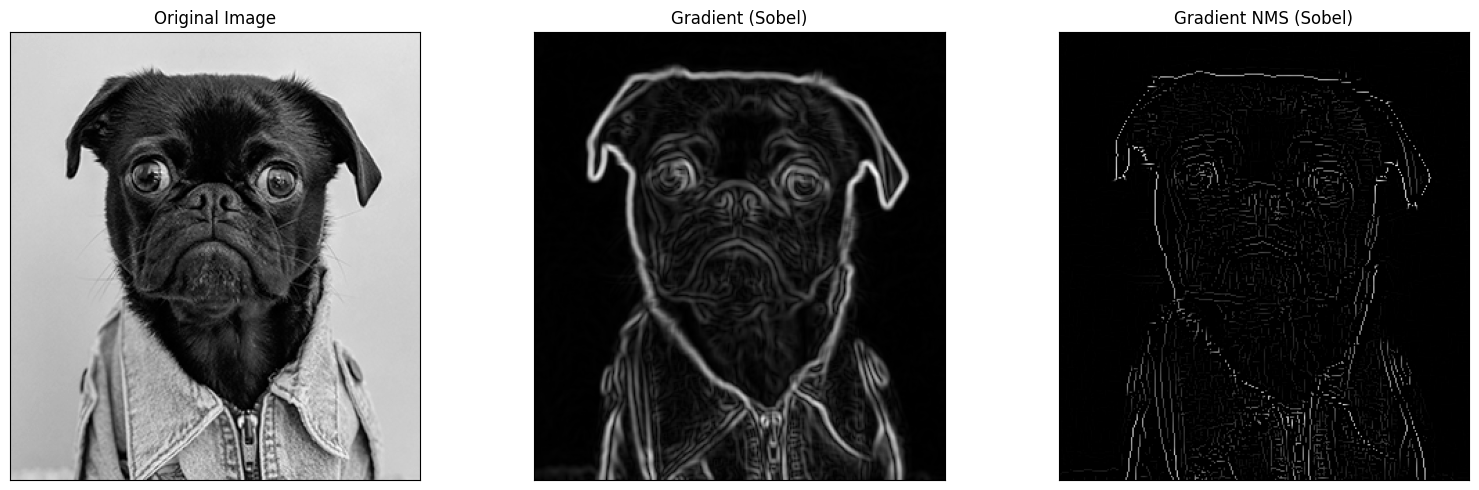

In [23]:
### DO NOT CHANGE ###
#@title Experiment with Non-Maximum Suppression { run: "auto" }
if __name__ == "__main__":

    import importlib
    import subprocess
    def check_and_install_library(library_name):
        try:
            importlib.import_module(library_name)
        except ImportError:
            subprocess.call(["pip", "-q", "install", library_name])

    check_and_install_library("wget")

    import wget
    import gdown
    import matplotlib.pyplot as plt
    import time
    import cv2
    import re
    from urllib.error import HTTPError

    class StopExecution(Exception):
        def _render_traceback_(self):
            pass

    url = "https://drive.google.com/file/d/15HWhYP_Kjbsz5AusTuuZtLi9nmTGiviY/view?usp=drive_link" #@param { type: "string" }
    s = 3
    n = 5
    gradient_kernel = "Sobel"

    now = time.strftime("%Y%m%d-%H%M%S")
    file_name = f"img_{now}.jpeg"

    if "drive.google.com" in url:
        id_match = re.search(r'/d/([a-zA-Z0-9_-]+)', url)
        if id_match:
            extracted_id = id_match.group(1)
        else:
            print(f"ERROR: Invalid Google Drive URL - provide another URL")
            raise StopExecution

        try:
            gdown.download(f"https://drive.google.com/uc?id={extracted_id}", file_name, quiet=True)
        except gdown.exceptions.FileURLRetrievalError:
            print(f"ERROR: Invalid Google Drive URL - please check the access permission or that the file exists or provide another URL")
            raise StopExecution
        except Exception as e:
            print(f"ERROR: Please contact course staff; failed to perform wget on image URL due to: {e}")
            raise StopExecution
    else:
        try:
            wget.download(url, file_name)
        except TypeError:
            print(f"ERROR: Invalid Image URL - provide another URL")
            raise StopExecution
        except HTTPError:
            print(f"ERROR: Failed make HTTP request to Image URL - provide another URL")
            raise StopExecution
        except Exception as e:
            print(f"ERROR: Please contact course staff; failed to perform wget on image URL due to: {e}")
            raise StopExecution

    try:
        img = cv2.imread(file_name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gaussian_filtered_img = convolve(img, gaussian_kernel(s, n))
        if gradient_kernel == "Sobel":
            Ix, Iy = gradients_xy_sobel(gaussian_filtered_img)
        elif gradient_kernel == "Prewitt":
            Ix, Iy = gradients_xy_prewitt(gaussian_filtered_img)
        elif gradient_kernel == "Roberts":
            Ix, Iy = gradients_xy_roberts(gaussian_filtered_img)

        G_magnitude = gradient_magnitude(Ix, Iy)
        G_angle = prep_for_NMS(gradient_direction(Ix, Iy))

        G_magnitude_NMS = NMS(G_magnitude, G_angle)

        fig, ax = plt.subplots(1, 3, figsize=(16, 5))
        ax[0].imshow(img, cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(G_magnitude, cmap="gray")
        ax[1].set_title(f"Gradient ({gradient_kernel})")
        ax[2].imshow(G_magnitude_NMS, cmap="gray")
        ax[2].set_title(f"Gradient NMS ({gradient_kernel})")
        for index, a in enumerate(ax):
            a.set_xticks([])
            a.set_yticks([])
        plt.tight_layout()
        plt.show()
    except NameError as e:
        print(f"ERROR: It appears some of the above code cells were not ran; please run the above code cell(s): {e}")
        raise StopExecution
    except Exception:
        print(f"ERROR: Required implementation is incorrect or incomplete")
        raise StopExecution

## Step 4: Two-Stage Hysteresis (10 pts)

In this section, you'll implement functions for Step 4: Two-Stage Hysteresis.

### Two Stage Hysteresis (10 pts)

`two_stage_hysteresis` (10 pts). The input into this function will be the gradient magnitude matrix, after applying non-maximal suppression (`NMS`) and being scaled (`rescale_matrix`) (i.e., assume those steps have already been done so no need to do them inside the function). The values in the input matrix, `M`, will take values between 0 to 1 inclusive. Given a `high_threshold` and `low_threshold` where `high_threshold` > `low_threshold`, perform two-stage hysteresis on the matrix `M`. The `high_threshold` and `low_threshold` parameters will be float numbers between `0` and `1`. The output should a binary matrix the same shape as `M` where `0` represents no edge and `1` represents an edge.

To recap, the algorithm for two-stage hysyeresis is:
- If a pixel value's gradient is above `high_threshold`, it's a strong edge and is kept (goes to one in the final binary image matrix).
- If a pixel value's gradient is less than the `low_threshold`, then it's suppressed (goes to zero in the final binary image matrix).
- If a pixel value's is between the `low_threshold` and `high_threshold` inclusive, then it's considered a weak edge. A weak edge will only remain if one of it's adjacent neigbors (for this implementation, it is the $3 \times 3$ window centered on the pixel) is marked as a strong edge (goes to one in the final binary image matrix). Otherwise, it's suppressed.

Note: for handling the gradients at the border, where gradient values need to be compared with gradient values that fall outside the image boundary, you can assume that the gradient values outside the gradient matrix are zero.

In the end, the pixel values that correspond to an edge will stay and everything else will go to zero. In the end, we'll be left with a binary map of which pixels correspond to edges.


#### Examples

##### Example 1

```python
M = [
    [0.0, 0.5, 0.1],
    [0.4, 0.0, 0.1],
    [0.4, 0.0, 0.2],
]
low_threshold = 0.15
high_threshold = 0.45

two_stage_hysteresis(M, low_threshold, high_threshold) = [
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
]
```

**Explanation**: For the entries in `M` that are greater than the `high_thresold`, it becomes 1. For entries in `M` between the `low_threshold` and `high_threshold`, it becomes 1 if any of it's neighbors are above the `high_threshold`. Everything else becomes 0.

##### Example 2

```python
M = [
    [0.3, 0.2, 0.2, 0.2],
    [0.0, 0.1, 0.2, 0.1],
    [0.5, 0.3, 0.2, 0.1],
]
low_threshold = 0.25
high_threshold = 0.45

two_stage_hysteresis(M, low_threshold, high_threshold) = [
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 0.0],
]
```

**Explanation**: For the entries in `M` that are greater than the `high_thresold`, it becomes 1. For entries in `M` between the `low_threshold` and `high_threshold`, it becomes 1 if any of it's neighbors are above the `high_threshold`. Everything else becomes 0.

#### Implementation

In [24]:
def two_stage_hysteresis(M: np.ndarray, low_threshold: float, high_threshold: float) -> np.ndarray:
    assert high_threshold > low_threshold, "High threshold must be greater than low threshold"

    H, W = M.shape
    output = np.zeros((H, W))

    strong = 1
    weak = 0.5

    # First stage of hysteresis: classify strong, weak, and non-edges
    strong_i, strong_j = np.where(M >= high_threshold)
    weak_i, weak_j = np.where((M >= low_threshold) & (M < high_threshold))

    output[weak_i, weak_j] = weak
    output[strong_i, strong_j] = strong

    output = np.pad(output, 1)

    # Define the 8-connected neighborhood for edge tracking
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

    # Second stage of hysteresis: edge tracking by hysteresis
    for i in range(1, H+1):
        for j in range(1, W+1):
            if output[i, j] == weak:
                # add index of conneted weak edges
                if any(output[i+dx, j+dy] == strong for dx, dy in neighbors):
                    # not assign strong right away to avoid nepotism
                    strong_i = np.append(strong_i, i)
                    strong_j = np.append(strong_j, j)
                else:
                    output[i, j] = 0  # Disconnected weak edges

    output[strong_i, strong_j] = strong

    return output[1:(H+1), 1:(W+1)]  # return the unpadded output matrix


### Two Stage Hysteresis Demo

After implementing all of the above functions, you can experiment with / visualize the effects of two-stage hysteresis. Feel free to provide a `url` link to an image or a google drive link to an image (make sure the permission is set to view access to anyone with the link; [steps can be found here](https://support.google.com/docs/answer/2494822?hl=en&co=GENIE.Platform%3DDesktop)). The `low_threshold` and `high_threshold` should be between 0 to 1 inclusive and the `low_threshold` should less than the `high_threshold`. Note: the gradient visualizations pre-processes the original image with a gaussian kernel of size $5 \times 5$ with $\sigma = 3$ and determines the gradients with the Sobel operator. **Note**: the below cell does not run automatically - you'll need to press play each time.

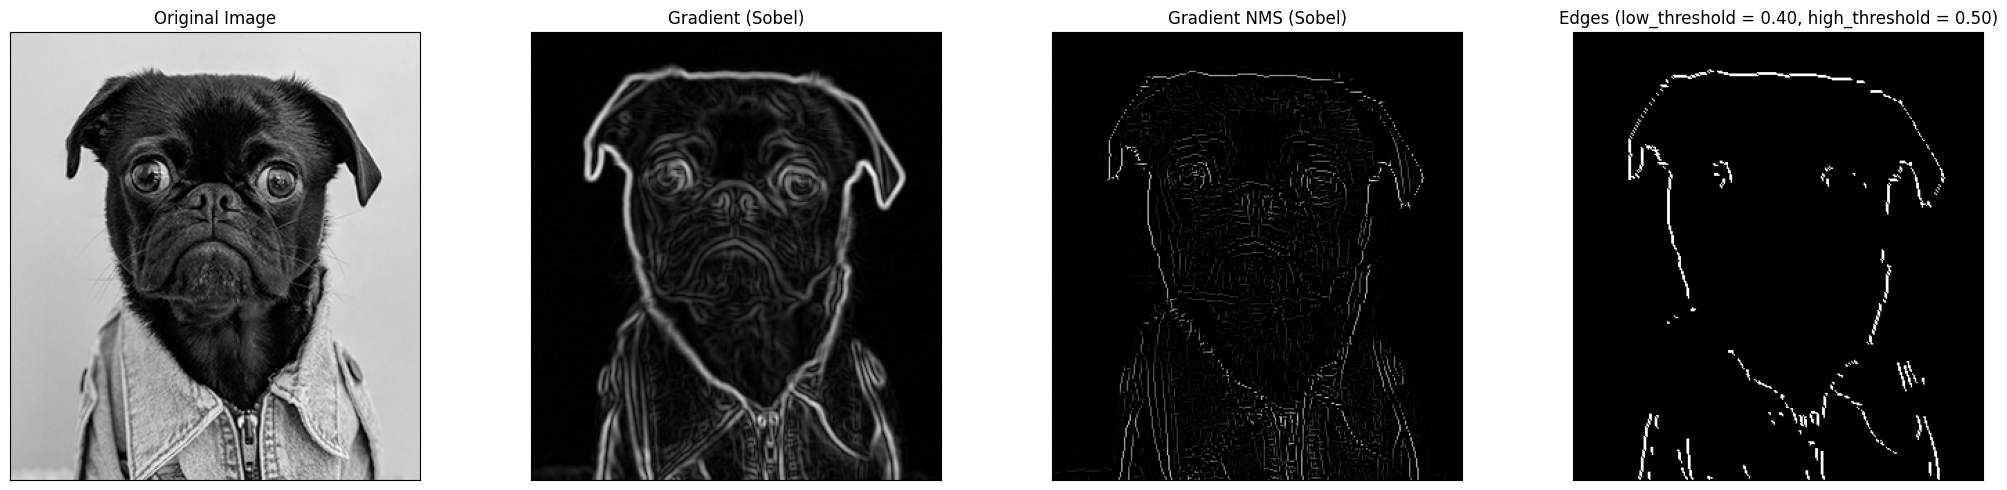

In [25]:
### DO NOT CHANGE ###
#@title Experiment with Two Stage Hysteresis
if __name__ == "__main__":

    import importlib
    import subprocess
    def check_and_install_library(library_name):
        try:
            importlib.import_module(library_name)
        except ImportError:
            subprocess.call(["pip", "-q", "install", library_name])

    check_and_install_library("wget")

    import wget
    import gdown
    import matplotlib.pyplot as plt
    import time
    import cv2
    import re
    from urllib.error import HTTPError

    class StopExecution(Exception):
        def _render_traceback_(self):
            pass

    url = "https://drive.google.com/file/d/15HWhYP_Kjbsz5AusTuuZtLi9nmTGiviY/view?usp=drive_link" #@param { type: "string" }
    s = 3
    n = 5
    gradient_kernel = "Sobel"
    low_threshold = 0.6 #@param {type:"number"}
    high_threshold = 0.5 #@param {type:"number"}

    if not (0 <= low_threshold <= 1):
        print(f"ERROR: Input `low_threshold` not valid number between 0 to 1; found `low_threshold` = {low_threshold}")
        raise StopExecution

    if not (0 <= high_threshold <= 1):
        print(f"ERROR: Input `high_threshold` not valid number between 0 to 1; found `high_threshold` = {high_threshold}")
        raise StopExecution

    if low_threshold > high_threshold:
        print(f"ERROR: Input `low_threshold` is higher than `high_threshold`; found `low_threshold` = {low_threshold} and `high_threshold` = {high_threshold}")
        raise StopExecution

    now = time.strftime("%Y%m%d-%H%M%S")
    file_name = f"img_{now}.jpeg"

    if "drive.google.com" in url:
        id_match = re.search(r'/d/([a-zA-Z0-9_-]+)', url)
        if id_match:
            extracted_id = id_match.group(1)
        else:
            print(f"ERROR: Invalid Google Drive URL - provide another URL")
            raise StopExecution

        try:
            gdown.download(f"https://drive.google.com/uc?id={extracted_id}", file_name, quiet=True)
        except gdown.exceptions.FileURLRetrievalError:
            print(f"ERROR: Invalid Google Drive URL - please check the access permission or that the file exists or provide another URL")
            raise StopExecution
        except Exception as e:
            print(f"ERROR: Please contact course staff; failed to perform wget on image URL due to: {e}")
            raise StopExecution
    else:
        try:
            wget.download(url, file_name)
        except TypeError:
            print(f"ERROR: Invalid Image URL - provide another URL")
            raise StopExecution
        except HTTPError:
            print(f"ERROR: Failed make HTTP request to Image URL - provide another URL")
            raise StopExecution
        except Exception as e:
            print(f"ERROR: Please contact course staff; failed to perform wget on image URL due to: {e}")
            raise StopExecution

    try:
        img = cv2.imread(file_name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gaussian_filtered_img = convolve(img, gaussian_kernel(s, n))
        if gradient_kernel == "Sobel":
            Ix, Iy = gradients_xy_sobel(gaussian_filtered_img)
        elif gradient_kernel == "Prewitt":
            Ix, Iy = gradients_xy_prewitt(gaussian_filtered_img)
        elif gradient_kernel == "Roberts":
            Ix, Iy = gradients_xy_roberts(gaussian_filtered_img)

        G_magnitude = gradient_magnitude(Ix, Iy)
        G_angle = prep_for_NMS(gradient_direction(Ix, Iy))

        G_magnitude_NMS = NMS(G_magnitude, G_angle)
        G_magnitude_NMS_scaled = rescale_matrix(G_magnitude_NMS)
        edges = two_stage_hysteresis(G_magnitude_NMS_scaled, low_threshold, high_threshold)

        fig, ax = plt.subplots(1, 4, figsize=(21, 5))
        ax[0].imshow(img, cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(G_magnitude, cmap="gray")
        ax[1].set_title(f"Gradient ({gradient_kernel})")
        ax[2].imshow(G_magnitude_NMS, cmap="gray")
        ax[2].set_title(f"Gradient NMS ({gradient_kernel})")
        ax[3].imshow(edges, cmap="gray")
        ax[3].set_title(f"Edges (low_threshold = {low_threshold:.2f}, high_threshold = {high_threshold:.2f})")
        for index, a in enumerate(ax):
            a.set_xticks([])
            a.set_yticks([])
        plt.tight_layout()
        plt.show()
    except NameError as e:
        print(f"ERROR: It appears some of the above code cells were not ran; please run the above code cell(s): {e}")
        raise StopExecution
    except Exception:
        print(f"ERROR: Required implementation is incorrect or incomplete")
        raise StopExecution

## Canny Edge Detection Demo (0 pts)

**Congrats on implementing the Canny Edge Detection algorithm**. In this section, you can experiment / demo with the algorithm by tuning / changing all the available parameters. Feel free to provide a `url` link to an image or a google drive link to an image (make sure the permission is set to view access to anyone with the link; [steps can be found here](https://support.google.com/docs/answer/2494822?hl=en&co=GENIE.Platform%3DDesktop)). **Note**: the below cell does not run automatically - you'll need to press play each time.

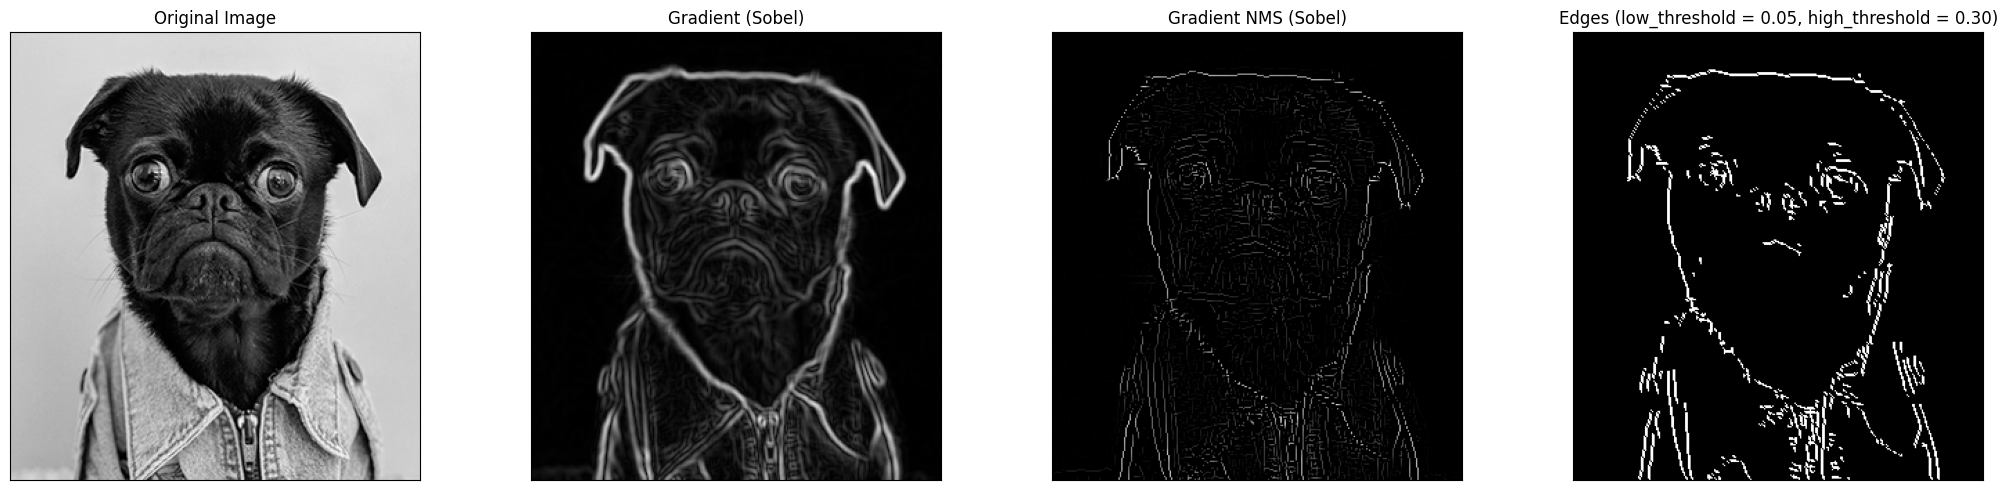

In [30]:
### DO NOT CHANGE ###
#@title Experiment with the Canny Edge Detection Algorithm
if __name__ == "__main__":

    import importlib
    import subprocess
    def check_and_install_library(library_name):
        try:
            importlib.import_module(library_name)
        except ImportError:
            subprocess.call(["pip", "-q", "install", library_name])

    check_and_install_library("wget")

    import wget
    import gdown
    import matplotlib.pyplot as plt
    import time
    import cv2
    import re
    from urllib.error import HTTPError

    class StopExecution(Exception):
        def _render_traceback_(self):
            pass

    url = "https://drive.google.com/file/d/15HWhYP_Kjbsz5AusTuuZtLi9nmTGiviY/view?usp=drive_link" #@param { type: "string" }
    s = 3 #@param { type: "slider", min: 1, max: 20, step: 1}
    n = 5 #@param { type: "slider", min: 3, max: 25, step: 2}
    gradient_kernel = "Sobel" #@param ["Sobel", "Prewitt", "Roberts"]
    low_threshold = 0.05 #@param {type:"number"}
    high_threshold = 0.3 #@param {type:"number"}

    if not (0 <= low_threshold <= 1):
        print(f"ERROR: Input `low_threshold` not valid number between 0 to 1; found `low_threshold` = {low_threshold}")
        raise StopExecution

    if not (0 <= high_threshold <= 1):
        print(f"ERROR: Input `high_threshold` not valid number between 0 to 1; found `high_threshold` = {high_threshold}")
        raise StopExecution

    if low_threshold > high_threshold:
        print(f"ERROR: Input `low_threshold` is higher than `high_threshold`; found `low_threshold` = {low_threshold} and `high_threshold` = {high_threshold}")
        raise StopExecution

    now = time.strftime("%Y%m%d-%H%M%S")
    file_name = f"img_{now}.jpeg"

    if "drive.google.com" in url:
        id_match = re.search(r'/d/([a-zA-Z0-9_-]+)', url)
        if id_match:
            extracted_id = id_match.group(1)
        else:
            print(f"ERROR: Invalid Google Drive URL - provide another URL")
            raise StopExecution

        try:
            gdown.download(f"https://drive.google.com/uc?id={extracted_id}", file_name, quiet=True)
        except gdown.exceptions.FileURLRetrievalError:
            print(f"ERROR: Invalid Google Drive URL - please check the access permission or that the file exists or provide another URL")
            raise StopExecution
        except Exception as e:
            print(f"ERROR: Please contact course staff; failed to perform wget on image URL due to: {e}")
            raise StopExecution
    else:
        try:
            wget.download(url, file_name)
        except TypeError:
            print(f"ERROR: Invalid Image URL - provide another URL")
            raise StopExecution
        except HTTPError:
            print(f"ERROR: Failed make HTTP request to Image URL - provide another URL")
            raise StopExecution
        except Exception as e:
            print(f"ERROR: Please contact course staff; failed to perform wget on image URL due to: {e}")
            raise StopExecution

    try:
        img = cv2.imread(file_name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gaussian_filtered_img = convolve(img, gaussian_kernel(s, n))
        if gradient_kernel == "Sobel":
            Ix, Iy = gradients_xy_sobel(gaussian_filtered_img)
        elif gradient_kernel == "Prewitt":
            Ix, Iy = gradients_xy_prewitt(gaussian_filtered_img)
        elif gradient_kernel == "Roberts":
            Ix, Iy = gradients_xy_roberts(gaussian_filtered_img)

        G_magnitude = gradient_magnitude(Ix, Iy)
        G_angle = prep_for_NMS(gradient_direction(Ix, Iy))

        G_magnitude_NMS = NMS(G_magnitude, G_angle)
        G_magnitude_NMS_scaled = rescale_matrix(G_magnitude_NMS)
        edges = two_stage_hysteresis(G_magnitude_NMS_scaled, low_threshold, high_threshold)

        fig, ax = plt.subplots(1, 4, figsize=(21, 5))
        ax[0].imshow(img, cmap="gray")
        ax[0].set_title("Original Image")
        ax[1].imshow(G_magnitude, cmap="gray")
        ax[1].set_title(f"Gradient ({gradient_kernel})")
        ax[2].imshow(G_magnitude_NMS, cmap="gray")
        ax[2].set_title(f"Gradient NMS ({gradient_kernel})")
        ax[3].imshow(edges, cmap="gray")
        ax[3].set_title(f"Edges (low_threshold = {low_threshold:.2f}, high_threshold = {high_threshold:.2f})")
        for index, a in enumerate(ax):
            a.set_xticks([])
            a.set_yticks([])
        plt.tight_layout()
        plt.show()
    except NameError as e:
        print(f"ERROR: It appears some of the above code cells were not ran; please run the above code cell(s): {e}")
        raise StopExecution
    except Exception:
        print(f"ERROR: Required implementation is incorrect or incomplete")
        raise StopExecution

## Problem Set Survey (5 pts)

Please fill out the survey questions (the first five are each worth 1 point; the last one is optional).


1.   `TIME` (1 pt): approximately how many hours did you spend on the problem set? Please use decimals to express partial hours (e.g., a value of `2.5` means two and half hours).
2.   `DIFFICULTY` (1 pt): on a scale of 1-10, how difficult was this problem set with 1 being very easy and 10 being very hard?
3.   `FAVORITE_PART` (1 pt): What was your favorite topic / learning from the unit (i.e., between the last pset and this pset)? This should contain at least 10 words.
4.   `WENT_WELL` (1 pt): What went well? Describe what went well with the course so far (this can be about the lecture, assignments, and/or other course content). This should contain at least 10 words.
5.   `CHALLENGING` (1 pt): What was challenging? Describe what was challenging or didn't go well with the course so far (this can be about the lecture, assignments, and/or other course content). This should contain at least 10 words.
6.   `COMMENTARY` (0 pt): If there is anything else you'd like to share with course staff, please add it here. If not, no need to change / edit the default string.


In [ ]:
#@title Problem Set Survey Questions
TIME = "8" #@param {type:"string"}

DIFFICULTY = "6" #@param ["", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

FAVORITE_PART = "Trying to understand the effect of each of the four steps of Canny Edge Detection" #@param {type:"string"}

WENT_WELL = "This assignment was a good refresher on matrix and array operations" #@param {type:"string"}

CHALLENGING = "Trying to visualize convolution operators and effect on images in an intuitive way" #@param {type:"string"}

COMMENTARY = "" #@param {type:"string"}

**<font color='red'>To submit, please download as a Python (.py) file and submit on Gradescope (navigate to File > Download > Download .py). Please use the correct file name and comment out any test / extraneous code to avoid any compile and parser issues </font>**